# Dijkstra's Algorithm for Robotic Path Planning

Dijkstra's Algorithm is a graph-based pathfinding algorithm that **guarantees** the "shortest" path in a weighted graph. In the context of robotics, it is particularly useful for path planning in known environments. Possible applications are:

1. Warehouse navigation: Robots use grid-based pathfinding to navigate around shelves.
2. Obstacle avoidance: Works well in structured environments with known obstacles.
3. Autonomous vehicles: Grid-based path planning can be used for local navigation.

This notebook explains Dijkstra's Algorithm in the context of robotic path planning. We'll visualize how the algorithm works and provide a Python implementation for an example grid-based graph.

The following concepts are important for the understanding the explanation that follows:

1. **Graph Representation**: The environment is represented as a graph where each node corresponds to a position (or grid cell), and edges represent possible movements.
2. **Weighted Edges**: The weights represent the cost of moving from one node to another, such as distance, difficulty or energy required.
3. **Optimal Path**: The algorithm finds the least-cost path from a start node to a goal node. Such a path is the shortest if the distances between nodes represent the cost for moving between them. However, if the costs include other aspects (like required energy, risk of collision etc.), the optimal path will not necessarily be the shortest one.

In this notebook, we will:
1. Define a grid environment for the robot.
2. Explain Dijkstra's Algorithm.
3. Implement the algorithm in Python.
4. Visualize the results and analyze its performance.

First, let's import the required libraries.

In [1]:
import heapq
import matplotlib.pyplot as plt
import numpy as np

### 1. Define the Environment
We represent the map of the world as a 10 x 10 grid. It is a 2D array where:
- `0` represents free space for the robot to navigate.
- `1` represents obstacles that block the robot's movement.

In [2]:
def create_grid():
    grid = np.array([
        [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]
        ])
    return grid

grid = create_grid()

The cost of moving to a specific cell is represented by the cost array. In a uniform world, you could consider that moving to a neighboring cell always has a cost of one. Or, you could assign higher costs to cells that have higher risk of collision, for example.

In [3]:
def create_costs():
    costs = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,]
    ])
    return costs

costs = create_costs()

The function below will allow us to visualize the environment.

In [4]:
def plot_grid(grid, path=None):
    """
    Plots the grid with optional path overlay.
    Args:
    - grid (2D array): The environment.
    - path (list of tuples): The path to overlay (optional).
    """
    plt.figure(figsize=(5, 5))

    # Plot the grid with inverted colors: 0 is black, 1 is white 
    # plt.imshow(grid, cmap="Greys", origin="upper")
    plt.imshow(grid, cmap="gray", origin="upper")

    # Anootate costs
    rows, cols = grid.shape
    for i in range(rows):
        for j in range(cols):
            if grid[i][j] == 0:
                plt.text(j, i, f'{costs[i][j]}', ha='center', va='center', color=('lightgray'), fontsize=10)

    if path:
        i = []
        j = []
        for (x, y) in path:
            plt.scatter(y, x, color="red")
            i.append(x)
            j.append(y)
        plt.plot(j,i, 'r')
    plt.title("Map of the Environment")
    # plt.grid(True)
    plt.show()

Let's create and visualize the map of our environment. The black cells represent the path that can be followed by the robot.

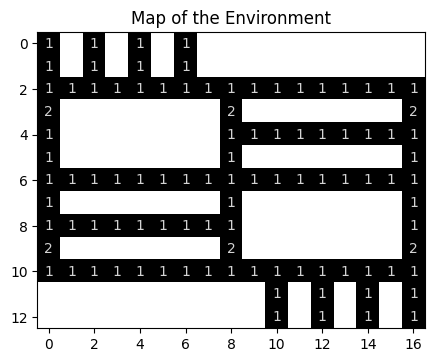

In [5]:
grid = create_grid()
plot_grid(grid)

### 2. Dijkstra's Algorithm

Dijkstra's Algorithm operates on graphs and finds the shortest path from a **start node** to a **goal node**. In a grid environment, **each cell is treated as a node**, and edges connect neighboring cells. 

### Algorithm Steps:
1. Initialize the start node with a distance of 0 and all other nodes with infinity.
2. Use a priority queue to explore nodes with the smallest known distance.
3. For each node, update the distances to its neighbors if a shorter path is found.
4. Stop when the goal node is reached or all reachable nodes have been explored.
5. Reconstruct the path from the goal to the start using parent pointers.

We'll now implement the algorithm step-by-step. 

The function below implements Dijkstra's algorithm for a grid-based environment. It returns the lowest-cost (shortest) path from start to goal as a list of tuples that represent the coordinates of each cell.

In [6]:
def dijkstra(grid, costs, start, goal):
    """
    Implements Dijkstra's Algorithm for a grid-based environment.
    Args:
    - grid (2D array): The environment grid.
    - costs (2D array): The cost of moving through each cell.
    - start (tuple): The start node (row, col).
    - goal (tuple): The goal node (row, col).

    Returns:
    - path (list of tuples): The shortest path from start to goal.
    """
    rows, cols = grid.shape
    visited = set()
    distances = {start: 0}  # Distance to the start node is 0
    parents = {start: None}  # A parent is the node that preceeds the current one: used to reconstruct the path

    priority_queue = []  # Priority queue ensures that nodes are processed in order of increasing distance
    heapq.heappush(priority_queue, (0, start))  # Initializes queue with the start node and distance to start

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        #  If a node has already been visited, it means the shortest distance to that node has been determined.
        if current_node in visited:
            continue 
        visited.add(current_node)

        # If the current node is the goal node, then the path has been found.
        if current_node == goal:
            break

        # Gets the coordinates of each neighboring cell
        for direction in directions:
            neighbor = (current_node[0] + direction[0], current_node[1] + direction[1])

            # Can only move within the boundaries of the world, and if there's no obstacle
            if (0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols and grid[neighbor] == 0):
                distance = current_distance + costs[neighbor]  # Use cost from the `costs` array

                # Updates the shortest known distance to a neighboring node and prepares it for further exploration
                if neighbor not in distances or distance < distances[neighbor]:
                    distances[neighbor] = distance  # Updates the shortest known distance to the neighbor
                    parents[neighbor] = current_node # Makes the current node be the parent of the neighbor to reconstruct the shortest path
                    heapq.heappush(priority_queue, (distance, neighbor))  # Adds the neighbor to the priority queue with its updated distance as the priority

    # Reconstruct path from the goal to the start
    path = []
    node = goal
    while node is not None:
        if node not in parents:
            print(f"Error: Node {node} has no parent. Path reconstruction failed.")
            return []
        path.append(node)
        node = parents[node]  # Gets the parent of the node
    path.reverse()  # Reverse the path to make it from start to the goal node
    return path

### 3. Execute the Algorithm
We will now run Dijkstra's Algorithm on the created grid to find the shortest path from the start to the goal cells.
In this example, the start cell is the top-left corner (0, 0) and the goal cell is at coordinates (12, 16).


Shortest Path: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (3, 16), (4, 16), (5, 16), (6, 16), (7, 16), (8, 16), (9, 16), (10, 16), (11, 16), (12, 16)]


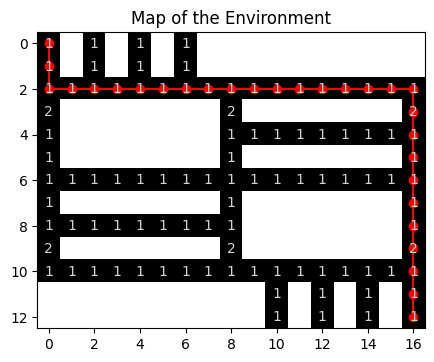

In [7]:
start =  (0, 0)
goal = (12, 16)

path = dijkstra(grid, costs, start, goal)
print("Shortest Path:", path)

# Visualize the Path
plot_grid(grid, path=path)

The resulting path is one of least cost from start to goal. By changing the cost of some cells and running Dijkstra's algorithm with no other change, the optimal path can be different. 

Below, we change the costs of a few cells and run the algorithm again. Observe that the resulting path is different than the one above.

Shortest Path: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (7, 8), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (7, 16), (8, 16), (9, 16), (10, 16), (11, 16), (12, 16)]


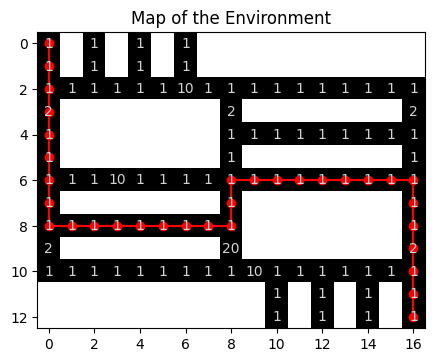

In [8]:
def create_costs():
    costs = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [2, 1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 1, 1, 1, 2,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,]
    ])
    return costs

costs = create_costs()

path = dijkstra(grid, costs, start, goal)
print("Shortest Path:", path)

# Visualize the Path
plot_grid(grid, path=path)

### Conclusion 

From the results above, we can conclude that Dijkstra's algorithm successfully found the shortest path from the start to the goal, while avoiding obstacles. In fact, the path is the least-cost route.

Important observations:
- Dijkstra's algorithm explores all reachable nodes and guarantees the least-cost path.
- The algorithm is computationally expensive for large maps or high-resolution grids.

As future work, explore the A* Algorithm, which adds heuristics to Dijkstra's to improve computational efficiency.

##### Back to the [main page](README.md).